<a href="https://colab.research.google.com/github/jerry910525/financial_project/blob/main/sharpe_optimize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import io
import json
import requests
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

def crawl_price(stock_id):

  d = datetime.datetime.now()
  url = "https://query1.finance.yahoo.com/v8/finance/chart/"+stock_id+"?period1=0&period2="+str(int(d.timestamp()))+"&interval=1d&events=history&=hP2rOschxO0"

  res = requests.get(url)
  data = json.loads(res.text)
  df = pd.DataFrame(data['chart']['result'][0]['indicators']['quote'][0], index=pd.to_datetime(np.array(data['chart']['result'][0]['timestamp'])*1000*1000*1000))
  return df

In [5]:
twii = crawl_price("2330.TW")

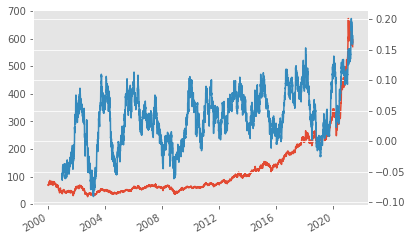

In [6]:
mean = twii['close'].pct_change().rolling(252).mean()
std = twii['close'].pct_change().rolling(252).std()

sharpe = mean / std

twii.close.plot()
sharpe.plot(secondary_y=True)

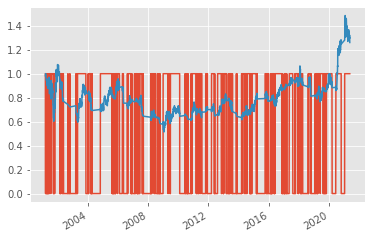

In [7]:
sr = sharpe
srsma = sr.rolling(60).mean()

# sharpe ratio 的斜率
srsmadiff = srsma.diff()

# 計算買入賣出點
buy = (srsmadiff > 0) & (srsmadiff.shift() < 0)
sell = (srsmadiff < 0) & (srsmadiff.shift() > 0)

# 計算持有時間
hold = pd.Series(np.nan, index=buy.index)
hold[buy] = 1
hold[sell] = 0
hold.ffill(inplace=True)
hold.plot()

# 持有時候的績效
adj = twii['close'][buy.index]
(adj.pct_change().shift(-1)+1).fillna(1)[hold == 1].cumprod().plot()

In [8]:
def backtest(a, b, c, d):
    sr = sharpe
    srsma = sr.rolling(a).mean()

    srsmadiff = srsma.diff() * 100
    ub = srsmadiff.quantile(b)
    lb = srsmadiff.quantile(c)
    
    buy = ((srsmadiff.shift(d) < lb) & (srsmadiff > ub))
    sell = ((srsmadiff.shift(d) > ub) & (srsmadiff < lb))

    hold = pd.Series(np.nan, index=buy.index)
    hold[buy] = 1
    hold[sell] = 0

    hold.ffill(inplace=True)
    hold.plot()

    adj = twii['close'][buy.index]
    (adj.pct_change().shift(-1)+1).fillna(1)[hold == 1].cumprod().plot()
    # eq = (adj.pct_change().shift(-1)+1).fillna(1)[hold == 1].cumprod().plot()
    # hold.plot()
    eq = (adj.pct_change().shift(-1)+1).fillna(1)[hold == 1].cumprod()
    if len(eq) > 0:
        return eq.iloc[-1]
    else:
        return 1

In [ ]:
maxeq = 0

for a in range(100,200,20):
    for b in np.arange(0.3, 0.9, 0.03):
        for c in np.arange(0.3, 0.6, 0.03):
            for d in range(60, 180, 10):
                
                eq = backtest(a,b,c,d)
                
                if maxeq < eq:
                    maxeq = eq
                    print(eq, a,b,c,d)

5.282654488034348 100 0.3 0.3 60
5.421059718436528 100 0.3 0.3 140
5.682317793509245 100 0.3 0.35999999999999993 60
5.7066877940553935 100 0.3 0.35999999999999993 70
6.6162544249227935 100 0.3 0.35999999999999993 90
7.246102898475392 100 0.3 0.4799999999999998 90
7.25379600248649 100 0.3 0.4799999999999998 100
7.897990490293045 100 0.3 0.5099999999999998 90
8.28553105312917 100 0.3 0.5099999999999998 100
9.293775803829435 100 0.32999999999999996 0.4799999999999998 100
10.806531954626903 100 0.32999999999999996 0.5099999999999998 100
10.817852676201186 120 0.3 0.35999999999999993 60
12.609292348890879 120 0.3 0.35999999999999993 70
13.049189399022694 120 0.3 0.3899999999999999 70
13.842661474494284 120 0.32999999999999996 0.3899999999999999 70


13.842661474494284

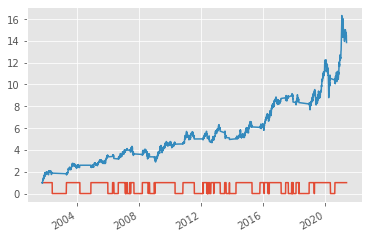

In [9]:
backtest(120 ,0.32999999999999996, 0.3899999999999999, 70)